In [3]:
#!pip install pyephem

import ephem
from astropy.coordinates import solar_system
from astropy import time
from astropy.coordinates import SkyCoord
import astroquery.heasarc

import astropy.units as u
import astropy.coordinates as coord
import numpy as np

import matplotlib as mpl
import matplotlib.pylab as plt

import pandas as pd
import io

import gzip

In [4]:
import time

import logging
logging.basicConfig(level='INFO')
logging.getLogger("oda_api").setLevel('INFO')

import oda_api.api


def get_oda(version="1.3"):
    return oda_api.api.DispatcherAPI(url={
                                "1.3": "http://in.internal.odahub.io/staging-1-3/dispatcher",
                                "1.2": "http://in.internal.odahub.io/staging-1.2/dispatcher",
                            }[version],
#                          cookies={
#                              "_oauth2_proxy": subprocess.check_output(["pass", "_oauth2_proxy"]).decode().strip()
#                          },
                          wait=True,
                         )

oda = get_oda()

isgri_image = oda.get_product(
               instrument='isgri', 
               product='isgri_image',    
               E1_keV=25,
               E2_keV=80,
               osa_version="OSA10.2",
               scw_list="066500220010.001",
            )

jemx_image = get_oda("1.2").get_product(
               instrument='jemx', 
               product='jemx_image',    
               E1_keV=25,
               E2_keV=80,
               osa_version="OSA10.2",
               scw_list="066500220010.001",
            )

ConnectionError: HTTPConnectionPool(host='in.internal.odahub.io', port=80): Max retries exceeded with url: /staging-1-3/dispatcher/api/par-names?instrument=isgri&product_type=isgri_image (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8434981eb0>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [ ]:
import astropy.io.fits as fits
from astropy import wcs
import numpy as np


jemx_image = fits.open("/mnt/sshfs/isdc/unsaved/astro/savchenk/data/reduced/ddcache/byscw/2077/207700740010.000/jemx_image.v2.2.1/JEMX.v0.jmx1/5cf19168/jmx1_sky_ima.fits.gz")[2]
jemx_var = jemx_image.data

isgri_image = fits.open("/mnt/sshfs/isdc/unsaved/astro/savchenk/data/reduced/ddcache/byscw/2077/207700740010.000/ii_skyimage.v2/3d87cb36/isgri_sky_ima.fits.gz")[3]
isgri_image.data.max()

In [ ]:

jemx_wcs = wcs.WCS(jemx_image.header)
jemx_wcs.low_level_wcs

jemx_deg_per_pix = np.linalg.eigvals(jemx_wcs.wcs.cd)[0]

In [ ]:
jemx_deg_per_pix

j_i, j_j = np.meshgrid(np.arange(jemx_var.data.shape[0]), np.arange(jemx_var.data.shape[1]))

In [ ]:
import scipy as sp
import scipy.ndimage as ndimage

jemx_var_sm = ndimage.filters.gaussian_filter(jemx_var, 1)

In [ ]:
plt.figure()

_ = plt.hist(jemx_var.flatten()**0.5, np.linspace(1e-5, 1e-3, 100))

In [ ]:
plt.figure(figsize=(10,10))

#isgri_var = isgri_image.mosaic_image_0_mosaic.to_fits_hdu_list()[3].data

j_i, j_j = np.meshgrid(np.arange(jemx_var.data.shape[0]), np.arange(jemx_var.data.shape[1]))

plt.contourf(
    (j_i - np.mean(j_i)) * jemx_deg_per_pix,
    (j_j - np.mean(j_j)) * jemx_deg_per_pix,
    (jemx_var_sm/np.nanmin(jemx_var_sm))**0.5,
    levels=(1, 1/0.5, 1/0.25, 1/0.1)
)


In [ ]:
plt.figure(figsize=(10,10))

isgri_var = isgri_image.data[:,:]

isgri_var[np.isnan(isgri_var)] = 1e9
isgri_var[isgri_var == 0] = 1e9

isgri_wcs = wcs.WCS(isgri_image.header)
isgri_wcs.low_level_wcs

isgri_deg_per_pix = np.linalg.eigvals(isgri_wcs.wcs.cd)[0]

i_i, i_j = np.meshgrid(np.arange(isgri_var.data.shape[0]), np.arange(isgri_var.data.shape[1]))


plt.contourf(
    (i_i - np.mean(i_i)) * isgri_deg_per_pix,
    (i_j - np.mean(i_j)) * isgri_deg_per_pix,
    (isgri_var/np.nanmin(isgri_var))**0.5,
    levels=(0, 0.5, 2),
    #levels=(0, 0.5, 1., 1/0.5, 1/0.25, 1/0.1)
)


In [ ]:
plt.figure()

plt.hist(
    R['Jupiter_from_sc_x_deg'], np.linspace(0, 10), cumulative=1, alpha=0.5)

plt.ylabel('pointings within radius')

plt

plt.axvline(3/2., label='JEMX "fully illuminated"', c='r')
plt.axvline(8./2., label='ISGRI fully coded', c='g')

plt.axvline(4.8, label='JEMX "part illuminated"', c='r', ls='--')
plt.axvline(8., label='ISGRI part coded', c='g', ls='--')


plt.grid()

plt.legend()

plt.xlabel("deg from Jupiter")

plt.savefig("jupiter-pointings.png")

In [270]:
h0 = np.histogram(
    SkyCoord(R['RA_X'], R['DEC_X'], unit='deg').separation(SkyCoord(10,20, unit='deg')).deg, np.linspace(0, 10))


<ipython-input-272-74c5d64f4fbf>:10: RuntimeWarning: invalid value encountered in true_divide
  (np.cumsum(h[0]) - np.cumsum(h[0])**0.5) / h[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:11: RuntimeWarning: invalid value encountered in true_divide
  (np.cumsum(h[0]) + np.cumsum(h[0])**0.5) / h[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:19: RuntimeWarning: invalid value encountered in true_divide
  100*(np.cumsum(h0[0]) - np.cumsum(h0[0])**0.5) / h0[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:20: RuntimeWarning: invalid value encountered in true_divide
  100*(np.cumsum(h0[0]) + np.cumsum(h0[0])**0.5) / h0[1][:-1]**2,


Text(0.5, 0, 'deg from Jupiter')

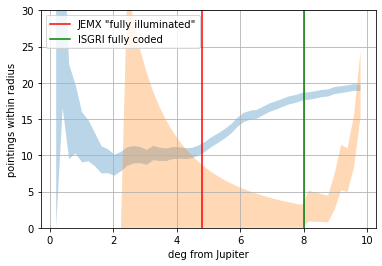

In [272]:
plt.figure()

h = np.histogram(
    R['Jupiter_from_sc_x_deg'], np.linspace(0, 10))

plt.ylabel('pointings within radius')

plt.fill_between(
    h[1][:-1],
    (np.cumsum(h[0]) - np.cumsum(h[0])**0.5) / h[1][:-1]**2,
    (np.cumsum(h[0]) + np.cumsum(h[0])**0.5) / h[1][:-1]**2,
    alpha=0.3
)



plt.ylim([0,30])

plt.axvline(4.8, label='JEMX "fully illuminated"', c='r')
plt.axvline(8., label='ISGRI fully coded', c='g')

plt.grid()

plt.legend()

plt.xlabel("deg from Jupiter")


In [ ]:
isgri_sensitivity_25_80_keV_1sigma_2ks = 1e-8 * u.erg/u.cm**2/u.s * (1./200.) # 200 sigma in a pointing


def total_sensitivity(body_name, lim_deg=10):
    sep = R[body_name+"_from_sc_x_deg"].astype(float)
    distance_cm = R[body_name+"_distance_cm"].astype(float)
    m = sep < lim_deg    
    
    sens = np.array(((distance_cm[m] * u.cm)**2 * isgri_sensitivity_25_80_keV_1sigma_2ks * (R['GOOD_ISGRI'][m].astype(float)/2000)**0.5)).to(u.erg/u.s)

    sens_combined = np.sum((sens**-2))**-0.5 # weighed mean uncertainty

    return dict(
        lum_sens_total=sens_combined,
        lum_reference=reference_object_erg_s[body_name]*u.erg/u.s,
    )
        
    
print(total_sensitivity('Jupiter'))
print(total_sensitivity('Venus'))


In [29]:
# https://arxiv.org/pdf/1012.1088.pdf claims Venus X-ray luminosity could be :

(55*u.MW).to(u.erg/u.s)

# they also claim that only Chandra could do it. Of course, INTEGRAL can also! Even if not formally. But actually she already did it.

<Quantity 5.5e+14 erg / s>

In [763]:
# heasarc claims

reference_object_erg_s['Venus']*u.erg/u.s 

<Quantity 5.5e+14 erg / s>

In [789]:
R['SCW_ID'][R['Venus_from_sc_x_deg']<10]

022500150010
036900690010
036900700010
036900710010
037000660010
037000670010
037000680010
037000690010
037000700010
037000710010
037000720010


In [ ]:
plt.figure(figsize=(12,10))

def split_segments(ijd, limit=60):
    if len(ijd) == 0:
        return []
    
    d_ijd = ijd[1:] - ijd[:-1]
    
    m_change_points = d_ijd > limit
    
    change_points = [ijd[0]] + list(ijd[:-1][m_change_points]) + [ijd[-1]]
    
    segments = []
    
    for i1,i2 in zip(change_points[:-1], change_points[1:]):
        segments.append(
            (ijd > i1) & (ijd < i2)
        )
    
    return segments
    
for m_segment in split_segments(R['IJD_START'][m_sun_angle].astype(float)):
    plt.plot(
        T[m_sun_angle][m_segment],
        R['Sun_distance_cm'][m_sun_angle][m_segment],
        lw=3,
        c='r'
    )

In [ ]:
# jupiter is best but has tons of observations

In [ ]:
# venus has no MF, but
# despite what is claimed, INTEGRAL can too
# https://arxiv.org/pdf/1012.1088.pdf

# if there is a flare when observation is possible, it would be nice to observe for a week, could be detection

2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/UTC


5037.8197997775305 5044.493882091212


2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4926764766796623/UTC
2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/SCWID
2021-03-24 19:54:16 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4926764766796623/SCWID
2021-03-24 19:54:18 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5037.8197997775305339/UTC
2021-03-24 19:54:18 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4938820912120718/UTC


2013-10-16T19:39:23.516
2013-10-23T11:50:04.228


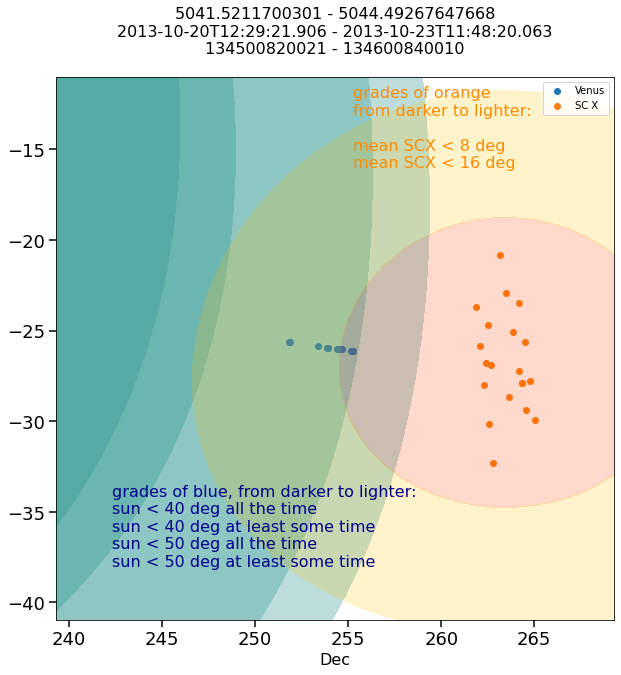

In [276]:
#from matplotlib import cmap 
plt.figure(figsize=(10,10))

#Venus
#C_future = get_body_coord_astropy_future(body_name)

m = R.Venus_from_sc_x_deg < 10

h = np.histogram(R['IJD_START'][m].astype(float), np.linspace(1000, 7000, 900))
i = h[0].argsort()[-2]

print(h[1][i], h[1][i+1])

ijd = R['IJD_START'][m].astype(float)

m &= ijd > h[1][i]
m &= ijd < h[1][i+1]

ra, dec= R.Venus_ra[m].astype(float),  R.Venus_dec[m].astype(float)


a_ra = np.linspace(np.mean(ra)-40, np.mean(ra)+40, 80)
a_dec = np.linspace(np.mean(dec)-40, np.mean(dec)+40, 80)

g_ra, g_dec = np.meshgrid(
    a_ra,
    a_dec,
)

g_coord = SkyCoord(g_ra, g_dec, unit="deg")
sun_distance_deg_first = g_coord.separation(Sun_coord[m][0]).deg
sun_distance_deg_last = g_coord.separation(Sun_coord[m][-1]).deg

sun_map = (sun_distance_deg_first > 40.).astype(float)
sun_map += (sun_distance_deg_first > 50.).astype(float)

sun_map += (sun_distance_deg_last > 40.).astype(float)
sun_map += (sun_distance_deg_last > 50.).astype(float)

plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_first,
    levels=[0, 40],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_first,
    levels=[0, 50],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_last,
    levels=[0, 40],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_last,
    levels=[0, 50],
    alpha=0.3
)


plt.scatter(
    ra, dec,
    label="Venus"
)

sc_ra, sc_dec = R['RA_X'][m].astype(float), R['DEC_X'][m].astype(float)

plt.scatter(
    sc_ra, sc_dec,
    label="SC X"
)

plt.ylim()


plt.xlim([np.mean(ra)-15, np.mean(ra)+15])
plt.ylim([np.mean(dec)-15, np.mean(dec)+15])

plt.title(f"{ijd[m].min()} - {ijd[m].max()}\n" + \
          ic.converttime("IJD", f"{ijd[m].min():.20g}", "UTC") + " - " + ic.converttime("IJD", f"{ijd[m].max():.20g}", "UTC") + "\n" + \
          ic.converttime("IJD", f"{ijd[m].min():.20g}", "SCWID") + " - " + ic.converttime("IJD", f"{ijd[m].max():.20g}", "SCWID") + "\n", 
          font_properties=font_prop)

plt.contourf(
    g_ra,
    g_dec,
    SkyCoord(np.mean(sc_ra), np.mean(sc_dec), unit='deg').separation(g_coord).deg,
    levels=[0, 8, 15],
    cmap="autumn",    
    alpha=0.2,
)

plt.xlabel("RA", font_properties=font_prop)
plt.xlabel("Dec", font_properties=font_prop)

#plt.xlim()

print(ic.converttime("IJD", f"{h[1][i]:.20g}", "UTC"))
print(ic.converttime("IJD", f"{h[1][i+1]:.20g}", "UTC"))

ax=plt.gca()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)

plt.text(np.mean(ra)-12,
         np.mean(dec)-12,
         "grades of blue, from darker to lighter:\nsun < 40 deg all the time\nsun < 40 deg at least some time" + \
         "\nsun < 50 deg all the time\nsun < 50 deg at least some time",     
         font_properties=font_prop, color="darkblue")

plt.text(np.mean(ra)+1,
         np.mean(dec)+10,
         "grades of orange\nfrom darker to lighter:\n" + \
         "\nmean SCX < 8 deg\nmean SCX < 16 deg",     
         font_properties=font_prop, color="darkorange")

plt.legend()

plt.savefig("venus-in-sgr-oct2013.png")

In [215]:
ic.converttime("IJD", f"{ijd[m].min():.20g}", "SCWID")

2021-03-19 16:26:49 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/SCWID


'134500820021'

In [300]:
def toau(x):
    return (np.array(x.astype(float)) * u.cm).to(u.au).value

In [307]:
R.Jupiter_from_sc_x_deg 

0         20.280395
1         20.104897
2         20.098546
3         20.092123
4         20.085820
            ...    
160548    92.881281
160549    93.164473
160550    93.437015
160551    93.707810
160552    95.841704
Name: Jupiter_from_sc_x_deg, Length: 160553, dtype: float64

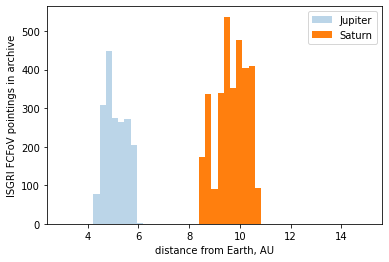

In [314]:
plt.figure()

m = R.Jupiter_from_sc_x_deg < 10
h = plt.hist(
    toau(R.Jupiter_distance_cm)[m],
    alpha=0.3,
    bins=np.linspace(3, 15),
    label="Jupiter"
)

m = R.Saturn_from_sc_x_deg < 10
plt.hist(
    toau(R.Saturn_distance_cm)[m],    
    bins=h[1],
    label="Saturn"
)

plt.ylabel("ISGRI FCFoV pointings in archive")
plt.xlabel("distance from Earth, AU")

plt.legend()

In [281]:
R.Jupiter_distance_cm

0         78941729298709.95
1         78313775145895.27
2         78289429840609.72
3         78265082661944.84
4          78240733684661.8
                ...        
160548    89658584415042.98
160549    89660478219692.66
160550    89662371521250.52
160551    89664262359622.25
160552    89666134110051.08
Name: Jupiter_distance_cm, Length: 160553, dtype: object

In [171]:
import integralclient as ic

ic.converttime("IJD", f"{h[1][i]:.20g}", "UTC")

2021-03-19 16:10:41 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5048.0480480480473489/UTC


'2013-10-27T01:08:04.167'

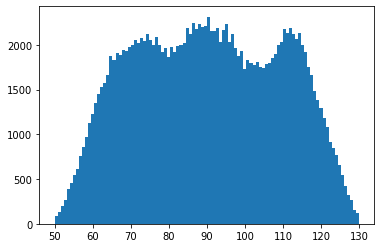

In [515]:
plt.figure()

# the reason why venus is rare is because of solar angle. inner planets have that restriction
# ISGRI has extra 10 deg for off-axis pointing, if designed
# it is never possible to observe Venus
# https://en.wikipedia.org/wiki/Elongation_(astronomy) of venus is up to 47 deg

_=plt.hist(
    Sun_coord.separation(scx_coord).deg,
    100
)

plt.axvline()

the reason why venus is rare is because of solar angle. inner planets have that restriction
ISGRI has extra 10 deg for off-axis pointing, if designed

In [400]:
import json

#json.dump(summary_by_body, open("summary_by_body.json", "wt"), indent=4)

summary_by_body

{'Venus': {'sensitivity_erg_s': 2023918343384943.8,
  'on_isgri_Ms': 0.168514,
  'on_pointings': 81},
 'Sun': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Mars': {'sensitivity_erg_s': 1151191493617938.0,
  'on_isgri_Ms': 3.744135,
  'on_pointings': 1588},
 'Mercury': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Jupiter': {'sensitivity_erg_s': 2.182728445837121e+16,
  'on_isgri_Ms': 4.360247,
  'on_pointings': 1853},
 'Saturn': {'sensitivity_erg_s': 6.4927958799684536e+16,
  'on_isgri_Ms': 9.066307,
  'on_pointings': 3207},
 'Uranus': {'sensitivity_erg_s': 1.855665674969776e+18,
  'on_isgri_Ms': 0.17205,
  'on_pointings': 67},
 'Neptune': {'sensitivity_erg_s': 4.746794849613064e+18,
  'on_isgri_Ms': 0.182509,
  'on_pointings': 61},
 'Pluto': {'on_isgri_Ms': 8.682008, 'on_pointings': 3813}}

In [411]:
pd.DataFrame([{'name':k, 'known_typical_lum': reference_object_erg_s.get(k, 0), **v} for k, v in summary_by_body.items()])

,name,known_typical_lum,sensitivity_erg_s,on_isgri_Ms,on_pointings
0,Venus,5.500000e+14,2.023918e+15,0.168514,81
1,Sun,0.000000e+00,inf,0.000000,0
2,Mars,4.000000e+13,1.151191e+15,3.744135,1588
3,Mercury,0.000000e+00,inf,0.000000,0
4,Jupiter,2.200000e+16,2.182728e+16,4.360247,1853
5,Saturn,8.700000e+14,6.492796e+16,9.066307,3207
6,Uranus,6.000000e+15,1.855666e+18,0.172050,67
7,Neptune,1.200000e+16,4.746795e+18,0.182509,61
8,Pluto,2.000000e+15,NaN,8.682008,3813


In [403]:
for o, d in summary_by_body.items():
    print(f"{o}")
    try:
        print(f" : known value {reference_object_erg_s[o]:5.3g} archive 1 sigma limit {d['sensitivity_erg_s']:5.4g} erg/s")
        print(f" : typical known value / 1 sigma limit in archive /  {reference_object_erg_s[o]/d['sensitivity_erg_s']:5.3g}")
        print(f" : potential for exposure improvement (400ks) {0.4/d['on_isgri_Ms']:5.3g}")    
        print(f" : typical known value / ToO limit /  {reference_object_erg_s[o]/(d['sensitivity_erg_s']/(0.4/d['on_isgri_Ms'])**0.5):5.3g}")
    except:
        print("nope")

Venus
 : known value 5.5e+14 archive 1 sigma limit 2.024e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.272
 : potential for exposure improvement (400ks)  2.37
 : typical known value / ToO limit /  0.419
Sun
nope
Mars
 : known value 4e+13 archive 1 sigma limit 1.151e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.0347
 : potential for exposure improvement (400ks) 0.107
 : typical known value / ToO limit /  0.0114
Mercury
nope
Jupiter
 : known value 2.2e+16 archive 1 sigma limit 2.183e+16 erg/s
 : typical known value / 1 sigma limit in archive /   1.01
 : potential for exposure improvement (400ks) 0.0917
 : typical known value / ToO limit /  0.305
Saturn
 : known value 8.7e+14 archive 1 sigma limit 6.493e+16 erg/s
 : typical known value / 1 sigma limit in archive /  0.0134
 : potential for exposure improvement (400ks) 0.0441
 : typical known value / ToO limit /  0.00281
Uranus
 : known value 6e+15 archive 1 sigma limit 1.856e+18 erg/s
 : typical known 

In [757]:
R.to_pandas().to_csv("archive-with-bodies.csv.gz", compression='gzip')

In [28]:
import requests
import re
import pandas as pd
import io


t = requests.get("https://heasarc.gsfc.nasa.gov/docs/heasarc/headates/what_kind.html").text
table = re.search("<pre>(.*?)</pre>", t, re.M | re.S).groups()[0]
table = re.sub(" - [0-9]\.[0-9]E[0-9]+? ", " "*8, table).replace("<"," ")
print(table)

d = pd.read_fwf(io.StringIO(table), header=1)
d['Lx_erg_s'] = d['Lx (erg/s)'].astype(float)

reference_object_erg_s = dict(zip(d['Object'], d['Lx_erg_s']))
reference_object_erg_s


Object      Lx (erg/s)        Lx (SI)        Comments

Moon        7.3E11            73 kW
Europa      1.5E13            1.5 MW

Io          2.0E13            2 MW
Mars        4.0E13          4 - 16 MW
Comets      1.0E14          10 - 5000 MW   Within 2 Au of the Sun
Earth       3.0E14            30 MW          My guess
Venus       5.5E14            55 MW
Saturn      8.7E14            87 MW
Io Plasma   1.0E15            100 MW
Torus
Pluto       2.0E15            200 MW         Surprisingly large!
Uranus      6.0E15            600 MW
Neptune     1.2E16           1200 MW
Jupiter     2.2E16           2200 MW



{nan: nan,
 'Moon': 730000000000.0,
 'Europa': 15000000000000.0,
 'Io': 20000000000000.0,
 'Mars': 40000000000000.0,
 'Comets': 100000000000000.0,
 'Earth': 300000000000000.0,
 'Venus': 550000000000000.0,
 'Saturn': 870000000000000.0,
 'Io Plasma': 1000000000000000.0,
 'Torus': nan,
 'Pluto': 2000000000000000.0,
 'Uranus': 6000000000000000.0,
 'Neptune': 1.2e+16,
 'Jupiter': 2.2e+16}